In [69]:
! pip install lazypredict

In [70]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [71]:
df = pd.read_csv('bioactivity_data_pIC50_pubchem_fp.csv')
df.pIC50

0     7.23
1     8.38
2     5.00
3     4.35
4     7.70
      ... 
470   9.54
471   9.42
472   8.07
473   4.51
474   4.52
Name: pIC50, Length: 475, dtype: float64

In [140]:
X = df.drop('pIC50', axis=1)
Y = df.pIC50

In [73]:

X.shape


(475, 881)

In [78]:
import numpy as np

# Get summary statistics all at once
min_vals = X_train.min(axis=0)
max_vals = X_train.max(axis=0)
std_vals = X_train.std(axis=0)
mean_vals = X_train.mean(axis=0)

# Create a summary
summary = np.vstack([min_vals, max_vals, mean_vals, std_vals])

print("Summary Statistics:")
print(f"Shape of data: {X_train.shape}")
print("\nFeature Statistics:")
print("              Min       Max      Mean       Std")
print("-" * 50)
for i in range(X_train.shape[1]):
    print(f"Feature {i:2d}: {min_vals[i]:8.2f} {max_vals[i]:8.2f} {mean_vals[i]:8.2f} {std_vals[i]:8.2f}")

# Quick check if scaling might be needed
scale_range = max_vals - min_vals
print("\nScale differences:")
print(f"Largest range: {scale_range.max():.2f}")
print(f"Smallest range: {scale_range.min():.2f}")

Summary Statistics:
Shape of data: (370, 162)

Feature Statistics:
              Min       Max      Mean       Std
--------------------------------------------------
Feature  0:     0.00     1.00     0.41     0.49
Feature  1:     0.00     1.00     0.65     0.48
Feature  2:     0.00     1.00     0.44     0.50
Feature  3:     0.00     1.00     0.26     0.44
Feature  4:     0.00     1.00     0.41     0.49
Feature  5:     0.00     1.00     0.35     0.48
Feature  6:     0.00     1.00     0.39     0.49
Feature  7:     0.00     1.00     0.56     0.50
Feature  8:     0.00     1.00     0.56     0.50
Feature  9:     0.00     1.00     0.71     0.45
Feature 10:     0.00     1.00     0.24     0.43
Feature 11:     0.00     1.00     0.24     0.43
Feature 12:     0.00     1.00     0.71     0.45
Feature 13:     0.00     1.00     0.29     0.45
Feature 14:     0.00     1.00     0.23     0.42
Feature 15:     0.00     1.00     0.47     0.50
Feature 16:     0.00     1.00     0.77     0.42
Feature 17:     0.

In [81]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.


In [82]:
import pickle

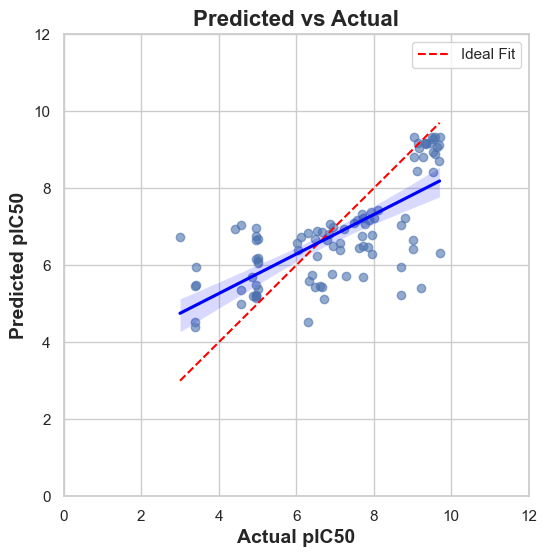


Model Performance:
-----------------
Train R²: 0.632
Train RMSE: 1.027
Test R²: 0.509
Test RMSE: 1.320

Cross-validation R² scores: 0.420 ± 0.107

Best Hyperparameters:
{'regressor__max_depth': 8, 'regressor__max_features': 'log2', 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}

Prediction Error Analysis:
-------------------------
Mean Error: 0.214
Std Error: 1.310
Max Abs Error: 3.822


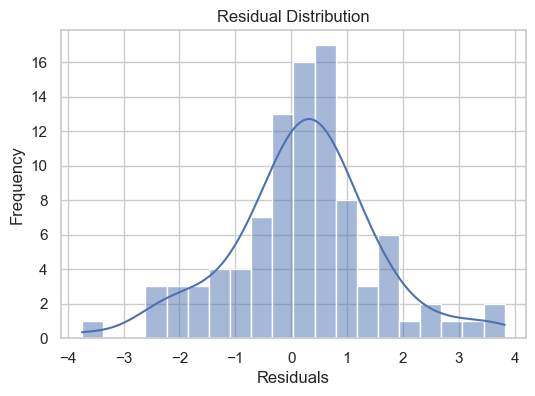

Model saved as random_forest_model.pkl


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

def create_ml_pipeline(X, y, random_state=42):
    """
    Creates and runs a complete machine learning pipeline with preprocessing, feature selection,
    hyperparameter tuning, and performance evaluation.

    Parameters:
    X: DataFrame or array of features
    y: Series or array of target values
    random_state: int for reproducibility

    Returns:
    dict with model, predictions, and metrics
    """
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # Define preprocessing
    numeric_features = X.columns
    preprocessor = ColumnTransformer(
        transformers=[('num', RobustScaler(), numeric_features)],
        remainder='passthrough'
    )

    # Define the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', SelectFromModel(
            RandomForestRegressor(n_estimators=100, random_state=random_state), threshold='mean'
        )),
        ('regressor', RandomForestRegressor(random_state=random_state))
    ])

    # Define parameter grid for hyperparameter tuning
    param_grid = {
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [6, 8, 10],
        'regressor__min_samples_split': [5, 10],
        'regressor__max_features': ['sqrt', 'log2']
    }

    # Perform grid search
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Get the best pipeline and make predictions
    best_pipeline = grid_search.best_estimator_
    train_predictions = best_pipeline.predict(X_train)
    test_predictions = best_pipeline.predict(X_test)

    # Evaluate model performance
    metrics = {
        'train_r2': r2_score(y_train, train_predictions),
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_predictions)),
        'test_r2': r2_score(y_test, test_predictions),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_predictions)),
        'cv_scores': cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='r2')
    }

    return {
        'best_pipeline': best_pipeline,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'train_predictions': train_predictions,
        'test_predictions': test_predictions,
        'metrics': metrics,
        'best_params': grid_search.best_params_
    }

def analyze_results(results):
    """Prints metrics and visualizes errors and predictions."""
    metrics = results['metrics']

    print("\nModel Performance:")
    print("-----------------")
    print(f"Train R²: {metrics['train_r2']:.3f}")
    print(f"Train RMSE: {metrics['train_rmse']:.3f}")
    print(f"Test R²: {metrics['test_r2']:.3f}")
    print(f"Test RMSE: {metrics['test_rmse']:.3f}")
    print(f"\nCross-validation R² scores: {metrics['cv_scores'].mean():.3f} ± {metrics['cv_scores'].std():.3f}")
    print("\nBest Hyperparameters:")
    print(results['best_params'])

    # Analyze prediction errors
    test_errors = results['y_test'] - results['test_predictions']
    print("\nPrediction Error Analysis:")
    print("-------------------------")
    print(f"Mean Error: {test_errors.mean():.3f}")
    print(f"Std Error: {test_errors.std():.3f}")
    print(f"Max Abs Error: {np.abs(test_errors).max():.3f}")

    # Visualize residuals
    plt.figure(figsize=(6, 4))
    sns.histplot(test_errors, kde=True, bins=20)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.show()

def run_pipeline(X, y):
    """Executes the entire pipeline and analyzes results."""
    results = create_ml_pipeline(X, y)
    analyze_results(results)
    return results


results = run_pipeline(X, Y)

# Save the model to a pickle file
# Assuming 'results' contains the best pipeline
if 'results' in locals():
    with open('random_forest_model.pkl', 'wb') as file:
        pickle.dump({
            'model': results['best_pipeline'],
            'feature_names': results['X_train'].columns
        }, file)
    print("Model saved as random_forest_model.pkl")


In [ ]:
with open("random_forest_model.pkl", "rb") as f:
    model = pickle.load(f)

